In [195]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import pickle
from scipy.stats import pearsonr
import numpy as np
import copy
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [196]:
version = 'v1'
device = 'mps'

In [197]:

geno_test_file = '../processed_data/test_geno_with_8_m_avg_all_data_{}.pkl'.format(version)
pheno_test_file = '../processed_data/test_pheno_with_8_m_avg_{}.pkl'.format(version)

geno_test_file_unique_env = '../processed_data/test_geno_unique_env_with_8_m_avg_all_data_{}.pkl'.format(version)
pheno_test_file_unique_env = '../processed_data/test_pheno_uniqeu_env_with_8_m_avg_{}.pkl'.format(version)


In [198]:
model_path = '../models/fc_global_marker_env_concatenated_{}.pt'.format(version)
pcc_model_path = '../processed_data/fc_model_env_pcc_middle_global_features_version_{}.pt'.format(version)
target_scaler_path = '../processed_data/target_scaler_global_features_{}.pkl'.format(version)
env_scaler_path = '../processed_data/env_scaler_global_features_{}.pkl'.format(version)
training_output_path = '../outputs/env_middle_training_outputs_global_features_' + version + '.pkl'
figure_loss_path = '../figures/loss_env_middle_global_features_' + version + '.jpeg'
figure_pcc_path = '../figures/pcc_env_moddle_global_features_' + version + '.jpeg'
test_output_all_env_path = '../outputs/predicted_all_env_global_features_' + version + '.pkl'
test_output_unique_env_path = '../outputs/predicted_unique_env_global_features_' + version + '.pkl'

In [199]:
def get_res_by_location(test_data):
    locations = test_data['Loc_no'].unique()
    trials = test_data['trial'].unique()

    result_dict ={}
    result_dict['location'] = []
    result_dict['trial'] = []
    result_dict['num_geno'] = []
    result_dict['pcc'] = []

    for location in locations:
        for trial in trials:
            partial_test = test_data[(test_data['Loc_no'] == location) & (test_data['trial'] == trial)]

            if len(partial_test) > 20:
               
                pcc = pearsonr(partial_test['Value'].to_numpy().reshape(-1,), partial_test['predicted'].to_numpy().reshape(-1,))[0]
                result_dict['location'].append(location)
                result_dict['trial'].append(trial)
                result_dict['num_geno'].append(len(partial_test))
                result_dict['pcc'].append(pcc)
   
    result_df = pd.DataFrame(result_dict)
   
    return result_df

In [200]:
def plot_scatter(x, y, xlabel, ylabel, xlim=None, ylim=None, axis_range='equal'):
    sns.scatterplot(x=x, y=y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
   
    if xlim == None and axis_range == 'equal':
        xlim = np.amin(x.tolist() + y.tolist()) - 0.5 , np.amax(x.tolist() + y.tolist()) +0.5
        ylim =xlim
    else:
        xlim = np.amin(x) - 0.5 , np.amax(x) +0.5
        ylim = np.amin(y) - 0.5 , np.amax(y) +0.5
   
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])



In [201]:

def plot_histogram(x, xlabel, ylabel):
    plt.figure(figsize=(16,8), dpi=600)
    sns.set(font_scale=1.2)
    sns.histplot(x, binwidth=0.1, binrange=(-1,1))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.savefig('../figures/marker_env_concatenated_{}.jpeg'.format(version))

In [202]:
def rescale_data(scaler, predicted):
    rescaled = scaler.inverse_transform(predicted.reshape(-1,1))
    
    return rescaled.reshape(-1,)

In [203]:
class FCModel(nn.Module):
    def __init__(self, num_env, num_geno, reduce_dim=2666, output_dim=1):
        super(FCModel, self).__init__()

        self.reduce_dim = reduce_dim
        self.num_geno = num_geno
        self.num_env = num_env

        

        self.fc1 = nn.Linear(num_geno, reduce_dim)
        self.relu1 = nn.ReLU()
        # self.maxpool1 = nn.MaxPool1d(2)
        
        
        self.fc2 = nn.Linear(reduce_dim, reduce_dim)
        self.relu2 = nn.ReLU()
        # self.maxpool2 = nn.MaxPool1d(2)
        
        self.fc3 = nn.Linear(reduce_dim, reduce_dim)
        self.relu3 = nn.ReLU()
        # self.maxpool3 = nn.MaxPool1d(2)

        self.fc4 = nn.Linear(reduce_dim, reduce_dim)
        self.relu4 = nn.ReLU()

        self.fc5 = nn.Linear(reduce_dim, reduce_dim)
        self.relu5 = nn.ReLU()

        self.fc6 = nn.Linear(reduce_dim, reduce_dim)
        self.relu6 = nn.ReLU()

        self.fc7 = nn.Linear(reduce_dim, reduce_dim)
        self.relu7 = nn.ReLU()

        self.fc8 = nn.Linear(reduce_dim, reduce_dim)
        self.relu8 = nn.ReLU()

        self.fc9 = nn.Linear(reduce_dim, reduce_dim)
        self.relu9 = nn.ReLU()

        self.fc10 = nn.Linear(reduce_dim, reduce_dim)
        self.relu10 = nn.ReLU()

        self.fc11 = nn.Linear(reduce_dim, reduce_dim)
        self.relu11 = nn.ReLU()

        self.fc12 = nn.Linear(reduce_dim, reduce_dim)
        self.relu12 = nn.ReLU()
        
        
        self.fc13 = nn.Linear(reduce_dim, reduce_dim)
        self.relu13 = nn.ReLU()
        
        
        self.fc14 = nn.Linear(reduce_dim, reduce_dim)
        self.relu14 = nn.ReLU()
        
        self.fc15 = nn.Linear(reduce_dim, 54)
        self.relu15 = nn.ReLU()
        
        
        self.regress = nn.Linear(54, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        d = x

        x = self.fc2(d)
        x = self.relu2(x)

        x = self.fc3(d)
        x = self.relu3(x)

        x = d + x
        d = x

        x = self.fc4(x)
        x = self.relu4(x)
        
        x = self.fc5(x)
        x = self.relu5(x)

        x = d + x
        d = x
        

        x = self.fc6(x)
        x = self.relu6(x)
        
        x = self.fc7(x)
        x = self.relu7(x)

        x = d + x
        d = x
        
        x = self.fc8(x)
        x = self.relu8(x)

        x = self.fc9(x)
        x = self.relu9(x)

        x = d + x
        d = x
        
        x = self.fc10(x)
        x = self.relu10(x)

        x = self.fc11(x)
        x = self.relu11(x)

        x = d + x
        d = x
        
        x = self.fc12(x)
        x = self.relu12(x)

        x = self.fc13(x)
        x = self.relu13(x)
        
        x = self.fc14(x)
        x = self.relu14(x)
        
        x = d + x
        d = x
        
        x = self.fc15(x)
        x = self.relu15(x)
        
        
       
        x = self.regress(x)
        
        return x

In [204]:
# class WheatDataset(Dataset):
#     def __init__(self, geno_file, target_file, scaler=None, output_scaler=None):
#         self.scaler = scaler
#         self.output_scaler=output_scaler
#         with open(geno_file, 'rb') as pfile:
#             self.data = pickle.load(pfile)

#         with open(target_file, 'rb') as pfile:
#             self.target = pickle.load(pfile)
        

#         ind = self.target <= 10
#         self.target = self.target[ind]
#         self.data = self.data[ind]
        
#         #Remove this line to run with global + local marker set
#         self.data = np.delete(self.data, np.arange(2000, 4052), axis=1)
        
        
#         self.target_original_space = self.target
#         self.target_original_space = self.target_original_space.reshape(-1,)

#         self.target = self.target.reshape(-1, 1)

#         print('number of markers: ', self.data.shape[1])
#         print(np.average(self.target))
#         print(np.max(self.target))

#         if scaler == None:
#             self.scaler= MinMaxScaler()
#             self.data[:, -81:] = self.scaler.fit_transform(self.data[:, -81:])
#         else:
#             self.data[:, -81:] = self.scaler.transform(self.data[:, -81:])
            
#         if self.output_scaler == None:
#             self.output_scaler = MinMaxScaler()
#             self.target = self.output_scaler.fit_transform(self.target)
#         else:
#             self.target = self.output_scaler.transform(self.target)

#         self.target = self.target.reshape(-1,)

#     def __len__(self):
#         return self.data.shape[0]
    
    
#     def __getitem__(self, ind):
#         return self.data[ind], self.target[ind], self.target_original_space[ind]

In [205]:
class WheatDataset(Dataset):
    def __init__(self, geno_file, target_file, scaler=None, output_scaler=None):
        self.scaler = scaler
        self.output_scaler=output_scaler
        with open(geno_file, 'rb') as pfile:
            all_data = pickle.load(pfile)

        all_data = all_data[all_data['Value'] <= 10]
        
        geno_data = all_data.iloc[:, 3:4055]
        weather = np.array(all_data['weather'].tolist())
        
        self.target = all_data['Value'].to_numpy()
        self.data = np.hstack((geno_data, weather))

        self.locations = all_data['Loc_no'].to_numpy()
        
        self.trials = all_data['trial'].to_numpy()
        
    
        
        #Remove this line to run with global + local marker set
        self.data = np.delete(self.data, np.arange(2000, 4052), axis=1)
        
        self.target_original_space = self.target
        self.target_original_space = self.target_original_space.reshape(-1,)

        self.target = self.target.reshape(-1, 1)

        print('number of markers: ', self.data.shape[1])
        print(np.average(self.target))
        print(np.max(self.target))

        if scaler == None:
            self.scaler= MinMaxScaler()
            self.data[:, -81:] = self.scaler.fit_transform(self.data[:, -81:])
        else:
            self.data[:, -81:] = self.scaler.transform(self.data[:, -81:])
            
        if self.output_scaler == None:
            self.output_scaler = MinMaxScaler()
            self.target = self.output_scaler.fit_transform(self.target)
        else:
            self.target = self.output_scaler.transform(self.target)

        self.target = self.target.reshape(-1,)

    def __len__(self):
        return self.data.shape[0]
    
    
    def __getitem__(self, ind):
        return self.data[ind], self.target[ind], self.target_original_space[ind]

In [206]:
def calculate_perf_measure(true, predicted):
    pcc, pval = pearsonr(true, predicted)
    
    return pcc

In [207]:
def evaluate(dataloader, model, criterion):
    model = model.to(device)
    model.eval()
    
    val_loss = 0
    predicted = []
    true = []
    true_original_space = []
    
    eval_loss = 0
    count = 0
    for data, target, true_scaled in dataloader:
        data = data.float()
        data = data.to(device)
        
        target = target.float()
        target = target.to(device)
        
        
        outputs = model(data)
        outputs= outputs.view(-1,)
        
        loss = criterion(target, outputs)
        
        eval_loss += loss.item()
        
        predicted += outputs.detach().cpu().numpy().tolist()
        true += target.detach().cpu().numpy().tolist()
        true_original_space += true_scaled.numpy().tolist()

        count+=1

    eval_loss = eval_loss / count    
    predicted = np.array(predicted)
    true = np.array(true)
    
    pcc = calculate_perf_measure(true, predicted)
    
    return eval_loss, pcc, np.array(true_original_space), predicted

In [208]:
def pcc_loss(true, predicted):
  x = predicted
  y = true

#   vx = x - torch.mean(x)
#   vy = y - torch.mean(y)

#   cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))
  
  x = torch.cat((true, predicted),0)
  cost = torch.corrcoef(x)
  cost = cost[0,1]
  #v2 code added here
  mse_loss = torch.mean((predicted -true)**2)

  total_cost = (1 - cost) + mse_loss

  return total_cost

In [209]:
with open(env_scaler_path, 'rb') as infile:
    env_scaler = pickle.load(infile)
    
with open(target_scaler_path, 'rb') as infile:
    target_scaler = pickle.load(infile)

In [210]:
with open(geno_test_file, 'rb') as infile:
    test_data = pickle.load(infile)

In [211]:
x = np.array(test_data['weather'].tolist())
x.shape

(12978, 81)

In [212]:
test_dataset = WheatDataset(geno_test_file, pheno_test_file, env_scaler, target_scaler) 
# test_dataset_unique_env = WheatDataset(geno_test_file_unique_env, pheno_test_file_unique_env, env_scaler, target_scaler) 

number of markers:  2081
4.814702491839821
10.0


In [213]:
criterion = nn.MSELoss().to(device)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [214]:
num_env = 81
num_geno=test_dataset.data.shape[1]
device = device
reduce_dim=770
model = FCModel(num_env, num_geno, reduce_dim)

In [215]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [216]:
model.eval()
test_loss, test_pcc, true_original_space, predicted= evaluate(test_loader, model, criterion)
print('test loss: ', test_loss)
print('test pcc: ', test_pcc)

test loss:  0.040503604309207894
test pcc:  0.37919302095548996


In [217]:
rescaled_predicted = rescale_data(target_scaler, predicted)
calculate_perf_measure(true_original_space, rescaled_predicted)

0.3791930203797948

In [218]:
test_loader.dataset.data

array([[0.30213824, 0.43864411, 0.29407952, ..., 0.15434111, 0.38424084,
        0.38278989],
       [0.30213824, 0.43864411, 0.29407952, ..., 0.09231297, 0.56957255,
        0.56685266],
       [0.30213824, 0.43864411, 0.29407952, ..., 0.10046328, 0.46434758,
        0.46116827],
       ...,
       [0.2028052 , 0.44730048, 0.2095086 , ..., 0.19037406, 0.46366871,
        0.46116827],
       [0.2028052 , 0.44730048, 0.2095086 , ..., 0.19037406, 0.46366871,
        0.46116827],
       [0.2028052 , 0.44730048, 0.2095086 , ..., 0.19037406, 0.46366871,
        0.46116827]])

In [219]:
df = pd.DataFrame({
    'Loc_no': test_loader.dataset.locations,
    'trial': test_loader.dataset.trials,
    'Value': test_loader.dataset.target_original_space,
    'predicted': rescaled_predicted
})

In [220]:
result_df = get_res_by_location(df)

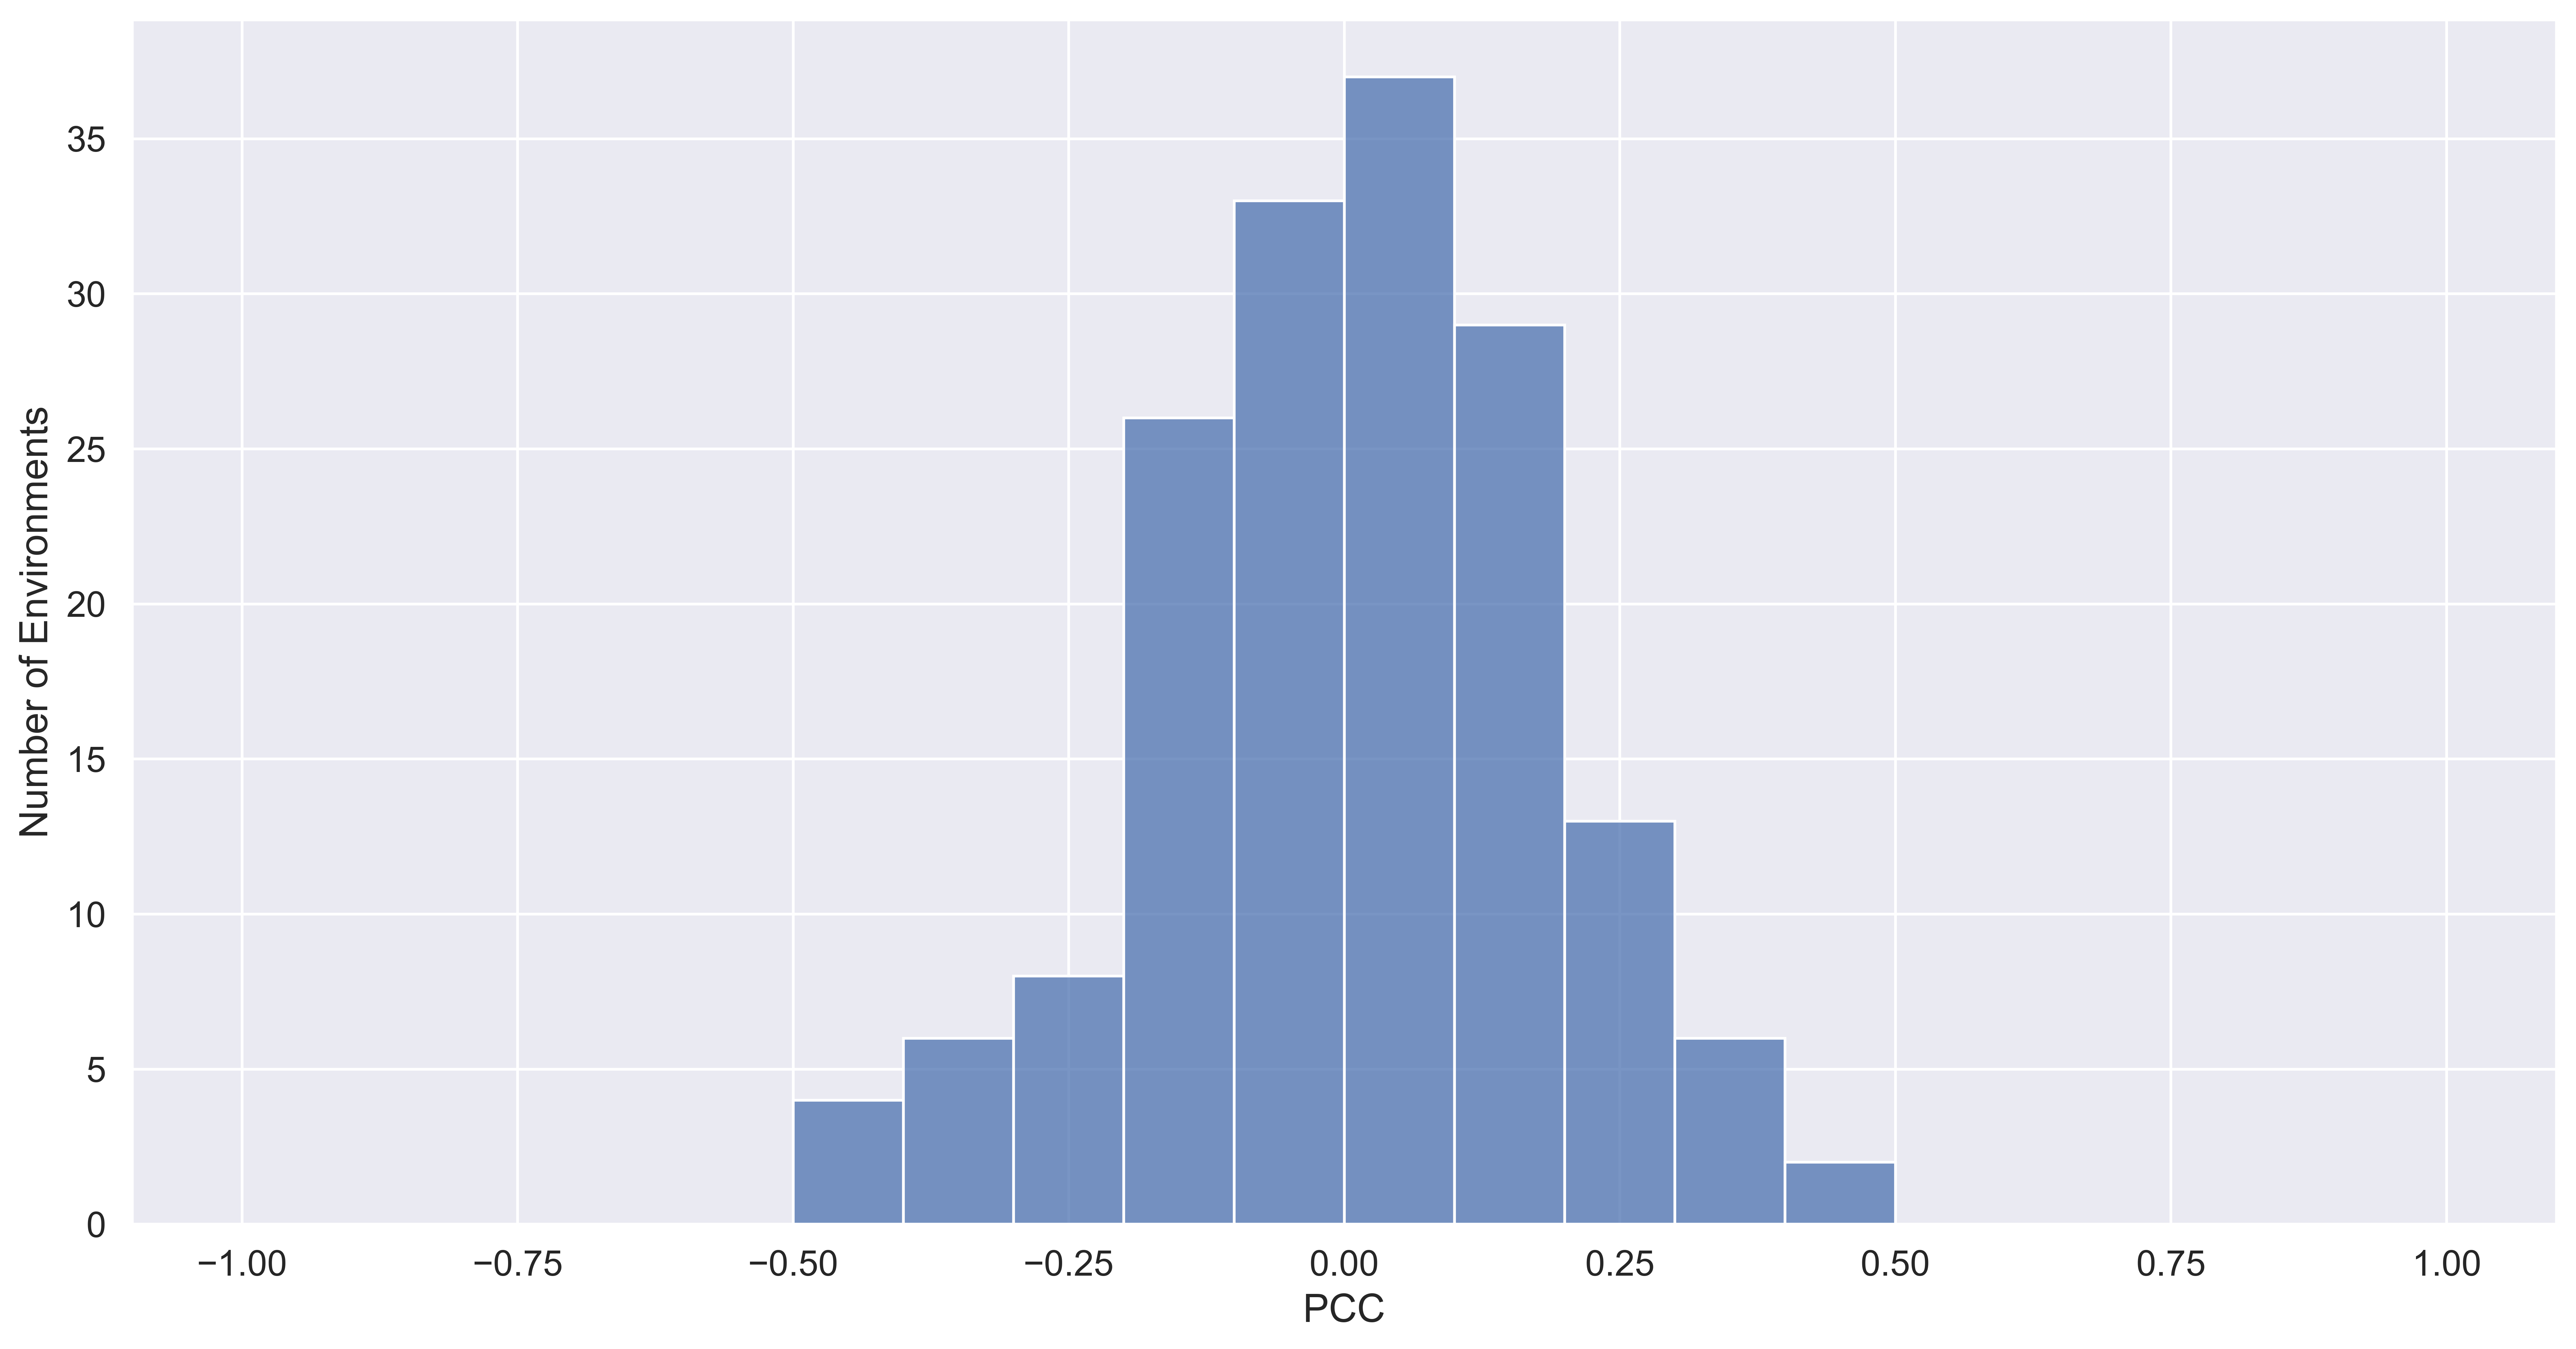

In [225]:
plot_histogram(result_df['pcc'].to_numpy(), xlabel='PCC', ylabel='Number of Environments')

In [222]:
np.sum((result_df['pcc'] > 0) & (result_df['pcc'] <=0.3))

79

In [223]:
np.sum((result_df['pcc'] > 0.3) )

8

In [224]:
np.sum((result_df['pcc'] < 0) )

77